In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import merge
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.core import Dense, Activation, Flatten, Reshape, Lambda
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers import Input
from keras.optimizers import SGD, adam
import scipy.io as sio
from keras import layers


Using TensorFlow backend.


In [2]:
bt_class = ['MPSK','MQAM','MFSK','GMSK']
inp_f = np.load('.\\dataset\\recognise\\fsk_data.npy')
inp_p = np.load('.\\dataset\\recognise\\psk_data.npy')
inp_q = np.load('.\\dataset\\recognise\\qam_data.npy')
inp_g = np.load('.\\dataset\\recognise\\gmsk_data.npy')
X = np.concatenate([inp_p,inp_q,inp_f,inp_g])
print(X.shape)
label_f = sio.loadmat('.\\dataset\\recognise\\fsk_label_onehot.mat')
label_p = sio.loadmat('.\\dataset\\recognise\\psk_label_onehot.mat')
label_q = sio.loadmat('.\\dataset\\recognise\\qam_label_onehot.mat')
label_g = sio.loadmat('.\\dataset\\recognise\\gmsk_label_onehot.mat')
Y = np.concatenate([label_p['between_class'], label_q['between_class'], label_f['between_class'], label_g['between_class']])
print(Y.shape)

(180000, 2, 1024)
(180000, 4)


In [3]:
# model for between-class

def conv_block2(x, nb_filter = [16, 16], kernel_size = (1,4)):
    k1, k2 = nb_filter
    
    #1
    out = Conv2D(k1, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    #2
    out = Conv2D(k2, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out) 
    #3
    out = merge([out,x],mode='sum')
       
    
    return out

def conv_block1(x, nb_filter = [16, 16], kernel_size = (1,4)):
    k1, k2 = nb_filter
    
    out = Conv2D(k1, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(x)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = Conv2D(k2, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    
    x = Conv2D(k2, kernel_size=kernel_size, strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(x)
    x = BatchNormalization()(x)
    
    
    out = merge([out,x],mode='sum')
    out = Activation('relu')(out)    
    
    return out
def get_bt_model():
        #init
    inp = Input([2, 1024])
    out = Reshape([2, 1024, 1])(inp)
    #part1
    out = Conv2D(32, kernel_size=(1, 4), strides=1, 
                        data_format='channels_last', padding='same',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    #part2
    out = conv_block2(out, [16, 32])
    out = conv_block2(out, [16, 32])
    
    out = Conv2D(32, kernel_size=(2, 4), strides=1, 
                        data_format='channels_last', padding='valid',
                        activation=None, init='he_normal')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    out = conv_block1(out, [32, 64])
    out = conv_block2(out, [32, 64])     

    #out = conv_block2(out, [16, 16])
    
    #part3
    out = layers.GlobalAveragePooling2D()(out)
    out = Dense(len(bt_class), activation='softmax')(out)
    #last

    model = Model(inp, out)
    return model
bt_model = get_bt_model()
bt_model.summary()

d:\python35\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_initializer="he_normal", activation=None, strides=1, data_format="channels_last", padding="same", kernel_size=(1, 4))`
d:\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, kernel_initializer="he_normal", activation=None, strides=1, data_format="channels_last", padding="same", kernel_size=(1, 4))`
  if __name__ == '__main__':
d:\python35\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_initializer="he_normal", activation=None, strides=1, data_format="channels_last", padding="same", kernel_size=(1, 4))`
  app.launch_new_instance()
d:\python35\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2, 1024)       0                                            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 2, 1024, 1)    0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 2, 1024, 32)   160         reshape_1[0][0]                  
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 2, 1024, 32)   128         conv2d_1[0][0]                   
___________________________________________________________________________________________

d:\python35\lib\site-packages\ipykernel_launcher.py:45: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
d:\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_initializer="he_normal", activation=None, strides=1, data_format="channels_last", padding="same", kernel_size=(1, 4))`
  if __name__ == '__main__':
d:\python35\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, kernel_initializer="he_normal", activation=None, strides=1, data_format="channels_last", padding="same", kernel_size=(1, 4))`
  app.launch_new_instance()


In [4]:
# split trainingset and val set
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,
                                                  test_size = 0.1, random_state=1)
print(X_train.shape)
print(X_val.shape)

(162000, 2, 1024)
(18000, 2, 1024)


In [5]:
from keras.callbacks import ReduceLROnPlateau
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=1e-6,
                                            mode='min')

In [6]:
from keras import optimizers
bt_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])
history = bt_model.fit(X_train, Y_train,
                  epochs=15,
                  batch_size=128,
                  verbose=1,
                  #validation_data=None)
                  validation_data=(X_val, Y_val),
                  callbacks=[learning_rate_reduction])  

Train on 162000 samples, validate on 18000 samples
Epoch 1/15
162000/162000 [==============================] - 250s - loss: 0.2664 - acc: 0.8920 - val_loss: 0.2298 - val_acc: 0.9107
Epoch 2/15
162000/162000 [==============================] - 231s - loss: 0.1189 - acc: 0.9560 - val_loss: 0.1008 - val_acc: 0.9608
Epoch 3/15
162000/162000 [==============================] - 231s - loss: 0.0965 - acc: 0.9636 - val_loss: 0.1655 - val_acc: 0.9283
Epoch 4/15
162000/162000 [==============================] - 231s - loss: 0.0840 - acc: 0.9685 - val_loss: 0.2299 - val_acc: 0.9037
Epoch 5/15
162000/162000 [==============================] - 230s - loss: 0.0758 - acc: 0.9717 - val_loss: 0.0611 - val_acc: 0.9774
Epoch 6/15
162000/162000 [==============================] - 231s - loss: 0.0704 - acc: 0.9735 - val_loss: 0.0880 - val_acc: 0.9646
Epoch 7/15
162000/162000 [==============================] - 231s - loss: 0.0657 - acc: 0.9754 - val_loss: 0.0745 - val_acc: 0.9718
Epoch 8/15
162000/162000 [======

In [8]:
bt_model.save_weights('.\\res\\Net_weight\\model_weights_betweenclass.h5')

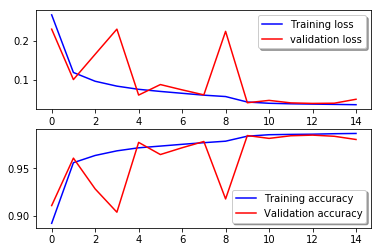

In [9]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

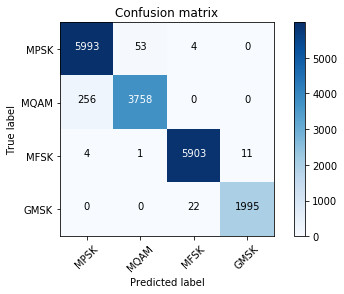

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(bt_class))
    plt.xticks(tick_marks, bt_class, rotation=45)
    plt.yticks(tick_marks, bt_class)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = bt_model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, normalize=False,classes = range(4)) 